### CAPSTONE: Predicting virus neutralization by antibodies using XGBoost

#### Lilian Nogueira

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from Bio import SeqIO
from collections import defaultdict
import plotly.express as px


import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
os.getcwd()

'/home/jovyan/work/files_notebook'

In [3]:
df_sorted_ic50 = pd.read_csv('df_ic50_final.csv')
df_sorted_ic50

,Antibody,Binding Type,Virus,Sequence,Neutralization
0,10-1074,gp120 V3 // V3 glycan (V3g),0013095_2_11,MRVKG-ILRNYQQW--------WIW--------SILGFW--MLMN-...,0
1,10-1074,gp120 V3 // V3 glycan (V3g),AIIMS706_70607F,MRVRG-IWRNYPQW--------WIW--------GVLG-----LLI-...,1
2,10-1074,gp120 V3 // V3 glycan (V3g),AIIMS709_70912B,MRVRG-TLRNYQQW--------WIW--------GILGFW--MLMI-...,0
3,10-1074,gp120 V3 // V3 glycan (V3g),AIIMS709_70915B,MRVMG-ILRNWQQW--------WIW--------GILGFW--MLMI-...,0
4,10-1074,gp120 V3 // V3 glycan (V3g),AIIMS709_709312B,MRVRG-TLRNYQQW--------WIW--------GILGFW--MLMI-...,0
...,...,...,...,...,...
11307,b12,gp120 CD4bs,A03349M1_VRC4A,MRVRG-IQRNYQNL--------WRW--------GTLLLG--MLMI-...,0
11308,b12,gp120 CD4bs,A07412M1_VRC12,VRVKE-TVRNYQHL--------WRW--------GIMLLG--MLMI-...,0
11309,b12,gp120 CD4bs,AC10_29,MRVRE-TRKNYQHLW-------WKW--------GMMLLG--MLMI-...,0
11310,b12,gp120 CD4bs,92UG005,MRVRG-IQRNYQHL--------WKW--------GTMLLW--ILMT-...,0


### Tokenizers

I am going to tokenize my data previous to train/ test split so the shuffling of the data don't interfere with the indices and shape of the data for futher analisys.

### One-Hot Encoder for Antibody Column


In [4]:
from sklearn.preprocessing import OneHotEncoder

# Instantiate the OneHotEncoder
ohe = OneHotEncoder()

# Fit the OneHotEncoder to the subcategory column and transform
# It expects a 2D array, so we first convert the column into a DataFrame
antibody = pd.DataFrame(df_sorted_ic50['Antibody'])
encoded = ohe.fit_transform(antibody)
encoded

<11312x17 sparse matrix of type '<class 'numpy.float64'>'
	with 11312 stored elements in Compressed Sparse Row format>

In [5]:
# Convert from sparse matrix to dense
dense_array = encoded.toarray()
dense_array

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [6]:
ohe.categories_

[array(['10-1074', '10E8', '3BNC117', 'N6', 'PG16', 'PG9', 'PGDM1400',
        'PGT121', 'PGT128', 'PGT145', 'VRC-CH31', 'VRC01', 'VRC07-523-LS',
        'VRC13', 'VRC26.08', 'VRC26.25', 'b12'], dtype=object)]

In [7]:
# Put into a dataframe to get column names
ab_df = pd.DataFrame(dense_array, columns=ohe.categories_[0], dtype=int)

ab_df

,10-1074,10E8,3BNC117,N6,PG16,PG9,PGDM1400,PGT121,PGT128,PGT145,VRC-CH31,VRC01,VRC07-523-LS,VRC13,VRC26.08,VRC26.25,b12
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11307,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
11308,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
11309,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
11310,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [8]:
#df_ab = pd.concat([df_sorted_ic50, encoded_df], axis=1)
#df_ab = df_ab.drop(['Antibody'], axis=1)

#df_ab

### One-Hot Encoder for Binding Type

In [9]:
# Instantiate the OneHotEncoder
ohe = OneHotEncoder()

# Fit the OneHotEncoder to the subcategory column and transform
# It expects a 2D array, so we first convert the column into a DataFrame
binding = pd.DataFrame(df_sorted_ic50['Binding Type'])
encoded_binding = ohe.fit_transform(binding)
encoded_binding

<11312x5 sparse matrix of type '<class 'numpy.float64'>'
	with 11312 stored elements in Compressed Sparse Row format>

In [10]:
# Convert from sparse matrix to dense
dense_array = encoded_binding.toarray()
dense_array

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [11]:
ohe.categories_

[array(['gp120 CD4bs', 'gp120 V2 // V2 glycan(V2g) // V2 apex',
        'gp120 V2 // V2 glycan(V2g) // V2 apex;quaternary structure',
        'gp120 V3 // V3 glycan (V3g)',
        'gp41 MPER (membrane proximal external region)'], dtype=object)]

In [12]:
# Put into a dataframe to get column names
binding_df = pd.DataFrame(dense_array, columns=ohe.categories_[0], dtype=int)

binding_df

,gp120 CD4bs,gp120 V2 // V2 glycan(V2g) // V2 apex,gp120 V2 // V2 glycan(V2g) // V2 apex;quaternary structure,gp120 V3 // V3 glycan (V3g),gp41 MPER (membrane proximal external region)
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,1,0
...,...,...,...,...,...
11307,1,0,0,0,0
11308,1,0,0,0,0
11309,1,0,0,0,0
11310,1,0,0,0,0


### One Hot Encoder for Aminoacid Sequences

Adapted from https://github.com/ronakvijay/Protein_Sequence_Classification

In [13]:
import numpy as np
import re

def string_to_array(seq_string):
    
    """ Convert sequence string into arrays """
    
    seq_string = seq_string.upper()
    #seq_string = re.sub('[^acgt]', 'n', seq_string)
    seq_string = np.array(list(seq_string))
    return seq_string

# create a label encoder with aminoacids alphabet
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# 1 letter code for 20 natural amino acids
label_encoder.fit(np.array(['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L','M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '-']))


LabelEncoder()

In [14]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encoder(seq_string):
    
    int_encoded = label_encoder.transform(string_to_array(seq_string))
    onehot_encoder = OneHotEncoder(sparse=False, dtype=int)
    int_encoded = int_encoded.reshape(len(int_encoded), 1) #index of aminoacids in the list
    onehot_encoded = onehot_encoder.fit_transform(int_encoded)
    onehot_encoded = np.delete(onehot_encoded, -1, 1) # it makes a list of lists
    onehot_encoded = np.concatenate(onehot_encoded)
    return onehot_encoded


#So let’s try it out with a sequence:
seq_test = "".join(['a', 'C', 'd', 'E', 'F', 'G', 'H', 'I', 'K', 'L','M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'])
one_hot_encoder(seq_test)

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [15]:
# Testing with a sequence from our dataset

#one_hot_encoder(df_sorted_ic50['Sequence'][0])

df_ohe = df_sorted_ic50['Sequence'].apply(one_hot_encoder).tolist()



In [16]:
df_ohe = pd.DataFrame(np.array(df_ohe))
df_ohe

,0,1,2,3,4,5,6,7,8,9,...,20790,20791,20792,20793,20794,20795,20796,20797,20798,20799
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11307,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11308,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11309,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11310,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
#Concantenating the encoded dataframes
#df_model = pd.concat([df_sorted_ic50, ab_df, df_binding_type, df_ohe], axis=1)
df_model = pd.concat([df_sorted_ic50, ab_df, binding_df, df_ohe], axis=1)

# Removing column Sequence
df_model = df_model.drop(['Sequence', 'Virus', 'Antibody', 'Binding Type'], axis=1)

df_model

,Neutralization,10-1074,10E8,3BNC117,N6,PG16,PG9,PGDM1400,PGT121,PGT128,...,20790,20791,20792,20793,20794,20795,20796,20797,20798,20799
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11307,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11308,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11309,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11310,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# Column names has to be strings
df_model = df_model.set_axis([str(i) for i in df_model.columns], axis=1)
df_model.head()

,Neutralization,10-1074,10E8,3BNC117,N6,PG16,PG9,PGDM1400,PGT121,PGT128,...,20790,20791,20792,20793,20794,20795,20796,20797,20798,20799
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Spliting my data set into train and test sets

In [19]:
 from sklearn.model_selection import train_test_split

In [20]:
X = df_model.loc[:, df_model.columns != 'Neutralization']
y = df_model['Neutralization']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=42)

In [21]:
print('X train and Y train shape is:', X_train.shape, y_train.shape)
print('X test and y test shape is:', X_test.shape, y_test.shape)

X train and Y train shape is: (7918, 20822) (7918,)
X test and y test shape is: (3394, 20822) (3394,)


### Building models

Decided to try XGBoost for a test. I want to add more estimators and parameters.

In [22]:
# To save the model to the disk
filename_search = 'neut_Xboost_bayessearch.sav'
filename_best_model = 'neut_Xboost_bayessearch_best_model.sav'

In [23]:
from xgboost import XGBClassifier

from skopt import BayesSearchCV
#from skopt.plots import plot_objective, plot_histogram
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


# Parameter search space for Bayesian optimization
xgb_search = {
    'xgb__n_estimators': Integer(1, 50),  # Number of trees
    'xgb__max_depth': Integer(3, 7),  # Maximum depth of each tree
    'xgb__learning_rate': Real(0.001, 0.1)  # Learning rate
}


# Create a pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()), # Scaler
    ('xgb', XGBClassifier(nthread=8))  # XGBoost model
])


# Perform Bayesian optimization using BayesSearchCV
bayes_search = BayesSearchCV(pipe,[(xgb_search, 100)], cv=5, n_jobs=15, pre_dispatch=30, n_iter=50, n_points=50)
#bayes_search = BayesSearchCV(pipe,[(xgb_search, 100)], cv=5)
bayes_search.fit(X_train, y_train)

# Best model and its accuracy
best_model = bayes_search.best_params_
best_accuracy_train = bayes_search.best_score_

# save the model to disk
import pickle

pickle.dump(bayes_search, open(filename_search, 'wb'))
pickle.dump(best_model, open(filename_best_model, 'wb'))



In [24]:
from xgboost import XGBClassifier

from skopt import BayesSearchCV
#from skopt.plots import plot_objective, plot_histogram
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pickle

#load the model results from the disk
bayes_search = pickle.load(open(filename_search, 'rb'))


# create model instance
best_model  = XGBClassifier(**bayes_search.best_params_)
best_accuracy = bayes_search.best_score_

# fit model
best_model.fit(X_train, y_train)

# Predictions on the test data using the best model
y_pred = best_model.predict(X_test)

# Evaluate the model using accuracy on test set
accuracy_test = best_model.score(X_test, y_test)


print("Best Accuracy:", best_accuracy)
print("Test Accuracy:", accuracy_test)
print("Best Model:", best_model)

[00:56:14] WARNING: ../src/learner.cc:767: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators" } are not used.

Best Accuracy: 0.8167469866064307
Test Accuracy: 0.8406010606953447
Best Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


In [25]:
from sklearn.metrics import classification_report

# Classification report

report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      2568
           1       0.71      0.57      0.64       826

    accuracy                           0.84      3394
   macro avg       0.79      0.75      0.77      3394
weighted avg       0.83      0.84      0.83      3394



Below, we have a confusion matrix reporting the number of true positives, false negatives, false positives, and true negatives. This allows more detailed analysis than simply observing the proportion of correct classifications (accuracy). When we have unbalanced datasets, like the one we are using, accuracy might yield misleading results, that is, when the numbers of observations in different classes vary greatly.

In [26]:
#Confusion matrix for model evaluation

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Non-Neutralizer", "Predicted Neutralizer"],
    index=["True Non-neutralizer", "True Neutralizer"]
)

display(cf_df)

,Predicted Non-Neutralizer,Predicted Neutralizer
True Non-neutralizer,2379,189
True Neutralizer,352,474


In our case, our model could predict 42% of the true neutralizers (352 out of 826). Precision for this model is 71% and recall is 57%.

It is also good to check the AUC (Area Under The Curve) ROC (Receiver Operating Characteristics) curve to evaluate our model performance.

AUC - ROC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1. By analogy, the higher the AUC, the better the model is at distinguishing between neutralizer antibodies and non-neutralizer antibodies against HIV.

As we can see below, our model has AUC near to the 1 (0.87) which means it has a good measure of separability between neutralizers and non-neutralizers.

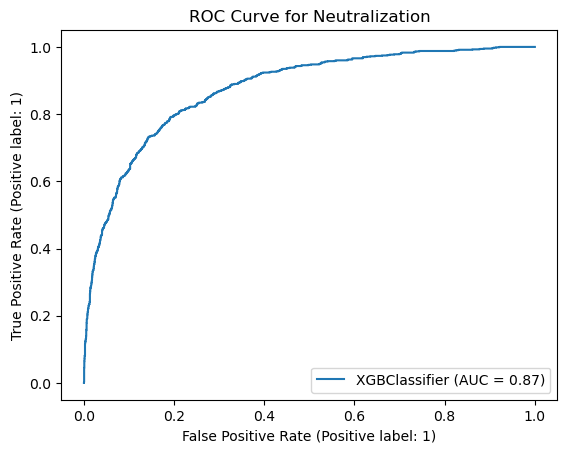

In [27]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title('ROC Curve for Neutralization')
plt.show()

There are several types of importance in the Xgboost. The default type is gain if you construct model with scikit-learn. When you access Booster object and get the importance with get_score method, then default is weight. You can check the type of the importance with xgb.importance_type.

The gain type shows the average gain across all splits where feature was used.

In [28]:
# Extract which features are more impotant in the model
best_model.feature_importances_

array([0.000817  , 0.00505897, 0.001491  , ..., 0.        , 0.        ,
       0.        ], dtype=float32)

In [29]:
type_importance = best_model.importance_type
print(type_importance)

None


In [30]:
feat_names = X_train.columns.values


In [31]:
sorted_idx = best_model.feature_importances_.argsort()
sorted_idx[0:9]

array([10410, 13792, 13791, 13790, 13789, 13788, 13787, 13786, 13785])

In [32]:
sorted_idx = list(reversed(sorted_idx))

In [33]:
list(best_model.feature_importances_[sorted_idx[0:9]])


[0.01592111,
 0.0132759195,
 0.011640753,
 0.010235766,
 0.00970887,
 0.008819334,
 0.008475339,
 0.0077382955,
 0.0071118036]

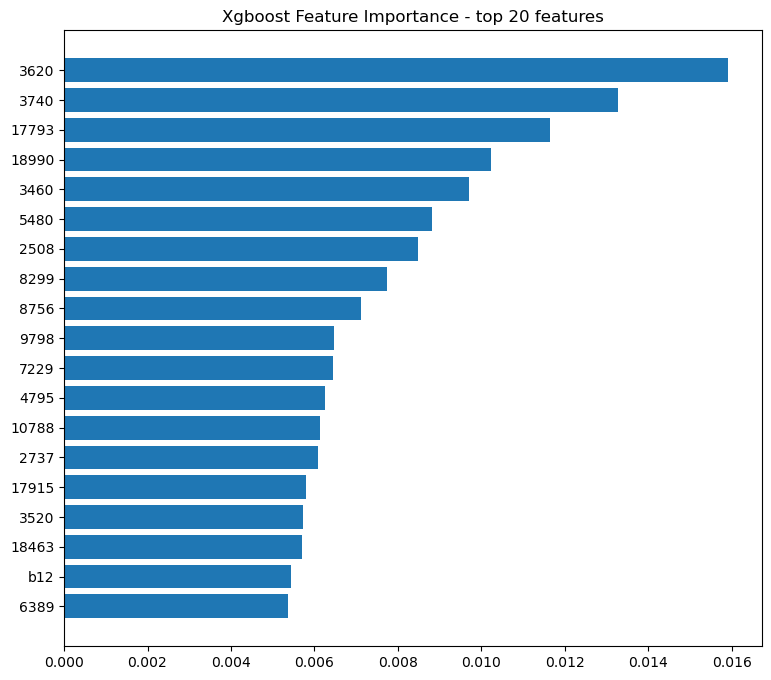

In [34]:
# Plot the chart
sliced = list(reversed(sorted_idx[0:19]))
plt.figure(figsize=(9,8))
plt.barh(feat_names[sliced], best_model.feature_importances_[sliced])
plt.title('Xgboost Feature Importance - top 20 features')
plt.show()

The numbers in the y-axis represent the position of the aminoacids in the virus sequence, except for b12 (this is one of the antibodies).

### Next Steps
Improve precision by testing the model using single antibodies.

This notebook is part of my Data Science Capstone Project delivered on June 2023. 